# Validierung mit Spartacus

Hier soll untersucht werden, wie gut die Analog-Methode funktioniert hat. 
Zur Validierung wird der hochaufgelösten Spartacusdatensatz verwendet, wobei es sich hier um gegitterte Beobachtungsdaten handelt. Dieser wurde für dieses Projekt von der ZAMG zur Verfügung gestellt. Dieser Datensatz reicht von bis 01.01.1961 bis 31.12.2017. Da die Reanalyse Daten bis 2018 gehen, kann es zu Datenlücken in der Verifikation kommen, wenn als Analogtag ein Tag im Jahr 2018 gefunden wurde.

Für die Validierung wird jeweils der tatsächliche TargetDay mit dem gefundenen analogen Tag verglichen. Hierbei werden folgende Verifikationsmaße verwendet:<br>
    1. MAE (mittlere absoluter Fehler): 
\begin{equation}
\text{MAE}= \overline{|(\text{AnalogDay}-\text{TargetDay})|}
\end{equation}    
    
    2. ME (Mittlerer Fehler):
\begin{equation}
\text{ME}= \overline{(\text{AnalogDay}-\text{TargetDay})}
\end{equation}    
    
    3. RMSE: 
\begin{equation}
\text{RMSE}= \sqrt{\overline{(\text{AnalogDay}-\text{TargetDay})^2}}
\end{equation}

    4. Pearson - Korrelationskoeffizient: berechnet mit numpy.corrcoeff wobei X,Y = AnalogDay, TargetDay
\begin{equation}
\text{CorrCoeff}= \frac{\text{COVAR}(X,Y)}{\text{VAR}(X)\cdot\text{VAR}(Y)}
\end{equation} 

In [1]:
import xarray as xr
import numpy as np
import cloudpickle
import pandas as pd

In [2]:
#Spartacus Datensatz laden
path="/mnt/c/Users/Kathi/Documents/Studium/Master/Klima/Übung/Projekt/sparta/"
path_to_Tx=path+"Tx/*.nc"

spartacus=xr.open_mfdataset(path_to_Tx, chunks={'time': 5000})

In [4]:
pathanalog="/mnt/c/Users/Kathi/Documents/Studium/Master/Klima/Übung/Projekt/Analoga.p"
analog_dates=cloudpickle.load(open( pathanalog,"rb"))

# Wie viele Analoga sind vorhanden:
nr = 3

#Jahr festlegen, für welches Verfikation gemacht werden soll
verifyear = '2015'
verifperiod = pd.date_range(verifyear+'-01-01', verifyear+'-12-31')

In [5]:
mae=[]
me=[]
rmse=[]
corr=[]
string=["Ref"]
for n in range(1,nr+1):
    string.append("Analoga"+str(n))

df=pd.DataFrame(analog_dates,columns=string)
df.index=df["Ref"]
df=df.loc[verifperiod]

analoga=df.to_numpy()

# Schleife für den Vergleich
for i, analog_list in enumerate(analoga):
    # "echte" Beobachtung aus den Spartacus-Daten holen
    ref_obs=spartacus.sel(time=analog_list[0])
    # alle NaN Werte entfernen
    ref_obs_values=ref_obs.Tx.values[~np.isnan(ref_obs.Tx.values)]
    
    mae_list=[]
    rmse_list=[]
    corr_list=[]
    me_list=[]
    for n in range(1,nr+1):
        try:
            analog=spartacus.sel(time=analog_list[n])

            analog_values=analog.Tx.values[~np.isnan(analog.Tx.values)]

            #berechnung des mf und hinzufügen zur liste
            me_calc=(analog_values-ref_obs_values).mean()
            me_list.append(me_calc)

            #berechnung des mae und hinzufügen zur liste
            mae_calc=(abs(analog_values-ref_obs_values)).mean()
            mae_list.append(mae_calc)

            #berechnung des rmse und hinzufügen zur liste
            rmse_calc=((analog_values-ref_obs_values)**2).mean()
            rmse_list.append(rmse_calc)

            #berechnung des corrcoeff und hinzufügen zur liste
            corr_calc=np.corrcoef(analog_values,ref_obs_values)[0][1]
            corr_list.append(corr_calc)
            
        except KeyError:
            me_list.append(np.nan)
            mae_list.append(np.nan)
            rmse_list.append(np.nan)
            corr_list.append(np.nan)
    mae.append(mae_list)
    me.append(me_list)
    rmse.append(rmse_list)
    corr.append(corr_list)

In [9]:
savepath="/mnt/c/Users/Kathi/Documents/Studium/Master/Klima/Übung/Projekt/"
# cloudpickle.dump(rmse, open(savepath + "rmse_verif_" + verifyear + ".p", "wb" ) )
# cloudpickle.dump(me, open(savepath + "me_verif_" + verifyear + ".p", "wb" ) )
# cloudpickle.dump(mae, open(savepath + "mae_verif_" + verifyear + ".p", "wb" ) )
# cloudpickle.dump(corr, open(savepath + "corr_verif_" + verifyear + ".p", "wb" ) )

## Darstellung

In [7]:
import matplotlib.pyplot as plt

In [10]:
me=np.array(cloudpickle.load(open(savepath + "me_verif_" + verifyear + ".p", "rb" )))
mae=np.array(cloudpickle.load(open(savepath + "mae_verif_" + verifyear + ".p", "rb" )))
rmse=np.array(cloudpickle.load(open(savepath + "rmse_verif_" + verifyear + ".p", "rb" )))
corr=np.array(cloudpickle.load(open(savepath + "corr_verif_" + verifyear + ".p", "rb" )))

In [11]:
verifyear = '2015'
verifperiod = pd.date_range(verifyear+'-01-01', verifyear+'-12-31')

string=[]
for i in range(1,nr+1):
    string.append("Analoga"+str(i))

/home/kathi/miniconda/envs/py3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


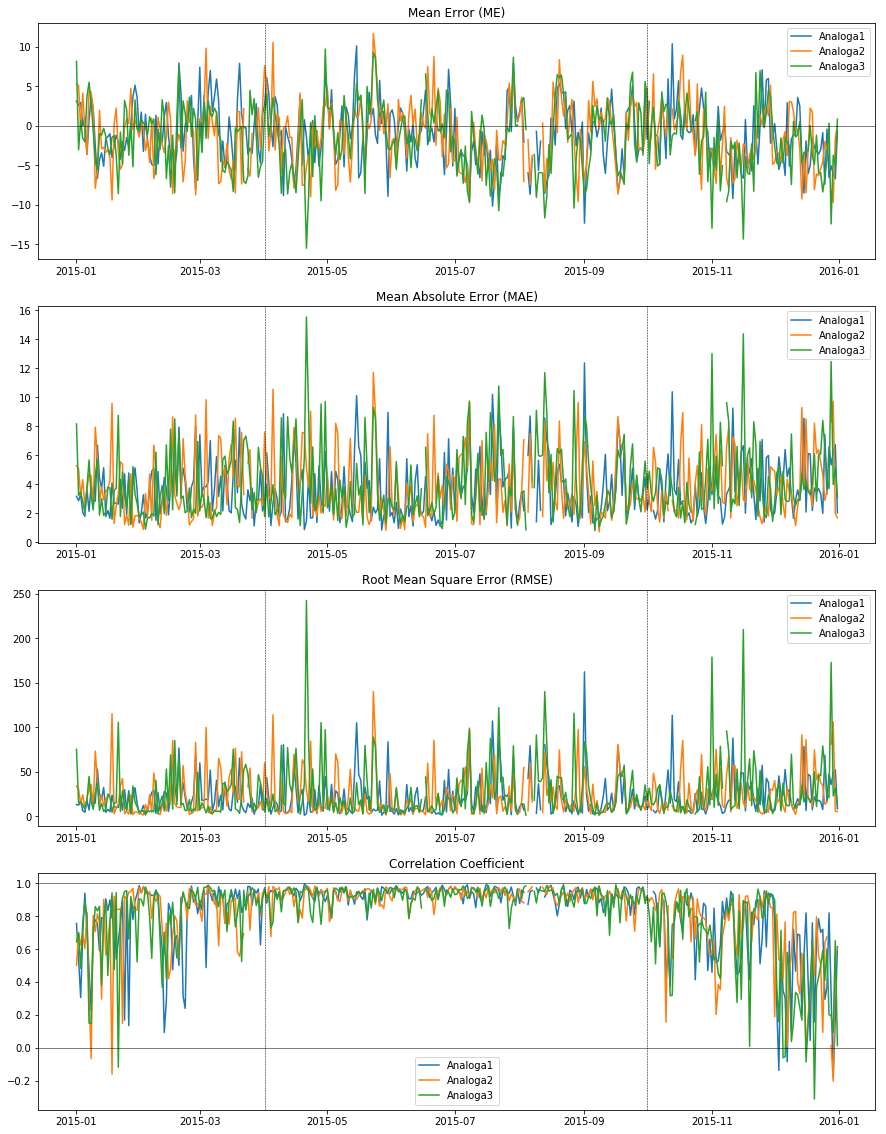

In [12]:
fig=plt.figure(figsize=(15,20))
#Subplot für ME
sub1=fig.add_subplot(411)
plt.title("Mean Error (ME)")
for n in range(nr):
    plt.plot(verifperiod,me[:,n],label=string[n])
plt.axhline(0,color="k",linewidth=0.5)
plt.axvline("2015-04-01",color="k",linestyle="--",linewidth=0.5)
plt.axvline("2015-10-01",color="k",linestyle="--",linewidth=0.5)
plt.legend()

#Subplot für MAE
sub1=fig.add_subplot(412)
plt.title("Mean Absolute Error (MAE)")
for n in range(nr):
    plt.plot(verifperiod,mae[:,n],label=string[n])
plt.axvline("2015-04-01",color="k",linestyle="--",linewidth=0.5)
plt.axvline("2015-10-01",color="k",linestyle="--",linewidth=0.5)
plt.legend()

#Subplot für RMSE
sub1=fig.add_subplot(413)
plt.title("Root Mean Square Error (RMSE)")
for n in range(nr):
    plt.plot(verifperiod,rmse[:,n],label=string[n])
plt.axvline("2015-04-01",color="k",linestyle="--",linewidth=0.5)
plt.axvline("2015-10-01",color="k",linestyle="--",linewidth=0.5)
plt.legend()   

#Subplot für Corr
sub1=fig.add_subplot(414)
plt.title("Correlation Coefficient")
for n in range(nr):
    plt.plot(verifperiod,corr[:,n],label=string[n])
plt.axhline(0,color="k",linewidth=0.5)
plt.axhline(1,color="k",linewidth=0.5)
plt.axvline("2015-04-01",color="k",linestyle="--",linewidth=0.5)
plt.axvline("2015-10-01",color="k",linestyle="--",linewidth=0.5)
plt.legend()

### Abschließend

Im Korrelationskoeffizienten sind wesentlich stärkere Zusammenhänge der beiden Zeitreihen in den Sommermonaten ersichtlich. In den Fehlermaßen spiegelt sich diese Tatsache jedoch nicht wieder. 
Dieser Zusammenhang scheint ausschließlich von den Jahreszeiten und der dadurch gegebenen Variabilität des Wetters herzurühren. 
Die Analogmethode liefert also mit dieser Konfiguration (90 % erklärte Varianz) in zwischen April und Oktober sehr brauchbare Ergebnisse. Für den Rest des Jahres muss gegebenen Falls der Pool erweitert werden oder die erklärte Varianz erhöht werden. 

Wie erwartet ist das erste Analogon das beste, unterscheidet sich aber in der für gut befunden Zeit kaum vom nachfolgenden 2. Analogon. Das 3. Analogon weist jedoch deutlich mehr Ausreißer zu geringeren Korrelation hin auf.